# OPTION PRICING CON HESTON VIA FFT 

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import pi, sqrt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.integrate import quad

## 1. Black-Sholes

In [2]:
# parametri
S = 105              
K = 105                 
T = 0.25                   
r = 0.03   
q = 0.005             
sigma = 0.2        

In [3]:
def black_scholes(S, K, T, r, sigma, q, option_type="call"):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
def greeks(S, K, T, r, sigma, q, option_type="call"):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    pdf = norm.pdf(d1)

    Delta = np.exp(-q*T) * norm.cdf(d1)
    Gamma = np.exp(-q*T) * pdf / (S * sigma * np.sqrt(T))
    Vega = S * np.exp(-q*T) * pdf * np.sqrt(T)

    return Delta, Gamma, Vega

In [4]:
call_price_bs = black_scholes(S, K, T, r, sigma, q, option_type="call")

start_bs = time.time()
end_bs = time.time()

Delta, Gamma, Vega = greeks(S, K, T, r, sigma, q, option_type="call")

print(f"Delta: {Delta:.4f}")
print(f"Gamma: {Gamma:.4f}")
print(f"Vega: {Vega:.4f}")

Delta: 0.5441
Gamma: 0.0377
Vega: 20.7863


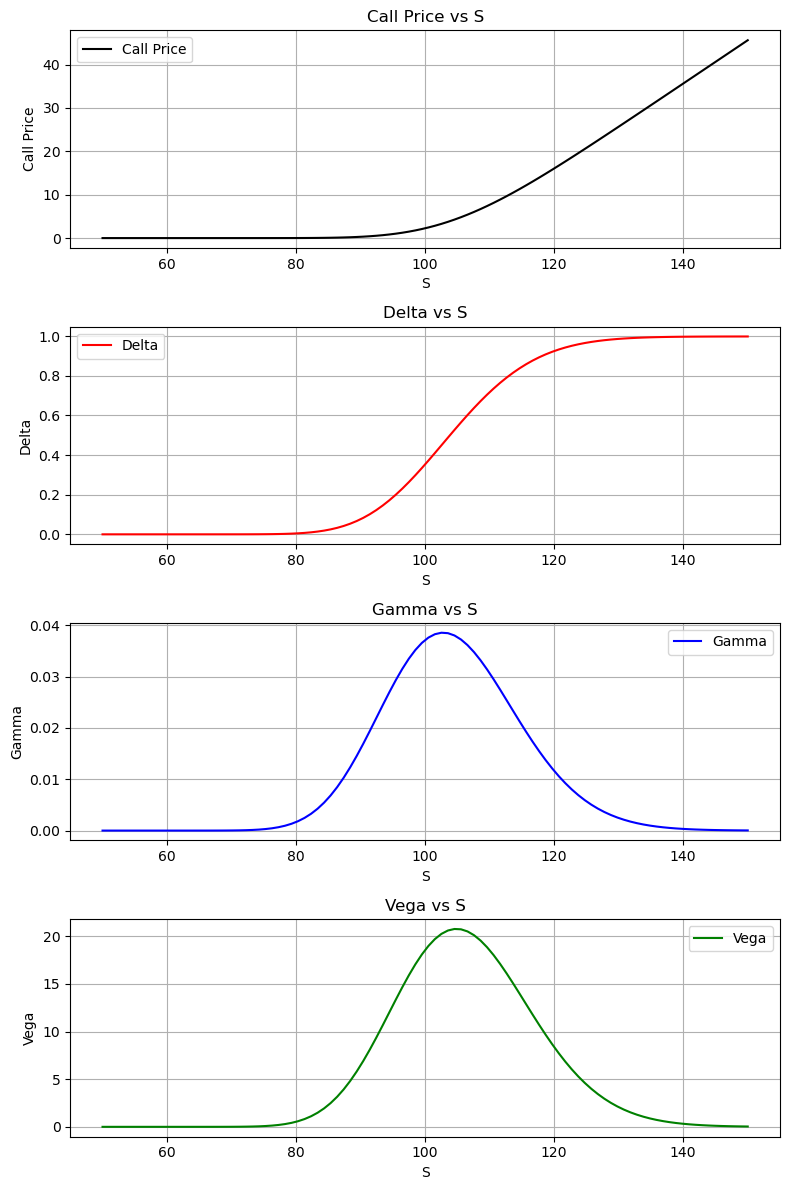

In [5]:
S_range = np.linspace(50, 150, 100)

deltas = [greeks(S, K, T, r, sigma, q, "call")[0] for S in S_range]
gammas = [greeks(S, K, T, r, sigma, q, "call")[1] for S in S_range]
vegas = [greeks(S, K, T, r, sigma, q, "call")[2] for S in S_range]
call_prices = [black_scholes(S, K, T, r, sigma, q, "call") for S in S_range]


def plot_greeks(S_range, deltas, gammas, vegas, call_prices):
    
    fig, axes = plt.subplots(4, 1, figsize=(8, 12))

    # Call Price vs S
    axes[0].plot(S_range, call_prices, label="Call Price", color='black')
    axes[0].set_xlabel("S")
    axes[0].set_ylabel("Call Price")
    axes[0].set_title("Call Price vs S")
    axes[0].legend()
    axes[0].grid()

    # Delta vs S
    axes[1].plot(S_range, deltas, label="Delta", color='red')
    axes[1].set_xlabel("S")
    axes[1].set_ylabel("Delta")
    axes[1].set_title("Delta vs S")
    axes[1].legend()
    axes[1].grid()

    # Gamma vs S
    axes[2].plot(S_range, gammas, label="Gamma", color='blue')
    axes[2].set_xlabel("S")
    axes[2].set_ylabel("Gamma")
    axes[2].set_title("Gamma vs S")
    axes[2].legend()
    axes[2].grid()

    # Vega vs S
    axes[3].plot(S_range, vegas, label="Vega", color='green')
    axes[3].set_xlabel("S")
    axes[3].set_ylabel("Vega")
    axes[3].set_title("Vega vs S")
    axes[3].legend()
    axes[3].grid()

    plt.tight_layout()
    plt.show()

plot_greeks(S_range, deltas, gammas, vegas, call_prices)


In [6]:
S_vals = np.linspace(50, 150, 120)
T_vals = np.linspace(1/365, 2.0, 100)  # da ~1 giorno a 2 anni
S_grid, T_grid = np.meshgrid(S_vals, T_vals, indexing='xy')
price_grid = np.vectorize(lambda s, t: black_scholes(s, K, t, r, sigma, q, "call"))(S_grid, T_grid)

fig = go.Figure(
    data=go.Surface(x=S_grid, y=T_grid, z=price_grid,
                    contours={"z": {"show": True, "usecolormap": True, "project_z": True}})
)
fig.update_layout(
    title="Superficie Prezzo Call: S vs T (σ fisso)",
    scene=dict(xaxis_title="S (spot)", yaxis_title="T (anni)", zaxis_title="Prezzo Call"),
    width=900, height=650
)
fig.show()


## 2. Dati

In [28]:
df = pd.read_csv('./df_call_AAPL.csv')
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
df

,lastTradeDate,underlying,S,type,strike,expiration_date,T_years,bid,ask,mid_price,lastPrice,iv,inTheMoney,stock,k,tradeDate,risk_free,q_t,Vega
0,2025-09-30 14:50:24+00:00,AAPL,256.690002,call,165.0,2025-10-24 00:00:00+00:00,0.064059,91.50,92.45,91.975,90.95,0.924805,True,AAPL,-0.441924,2025-09-30,0.03845,0.004,3.406351
1,2025-09-19 17:31:40+00:00,AAPL,256.690002,call,170.0,2025-10-24 00:00:00+00:00,0.093890,86.45,87.75,87.100,76.03,0.919923,True,AAPL,-0.412071,2025-09-19,0.03878,0.004,8.521455
2,2025-10-03 19:37:08+00:00,AAPL,256.690002,call,175.0,2025-10-24 00:00:00+00:00,0.055295,81.35,82.45,81.900,83.45,0.779299,True,AAPL,-0.383083,2025-10-03,0.03858,0.004,2.176114
3,2025-09-22 19:46:20+00:00,AAPL,256.690002,call,180.0,2025-10-24 00:00:00+00:00,0.085414,76.45,77.90,77.175,78.35,0.831545,True,AAPL,-0.354912,2025-09-22,0.03848,0.004,8.398109
4,2025-09-29 14:33:13+00:00,AAPL,256.690002,call,185.0,2025-10-24 00:00:00+00:00,0.066832,71.85,72.30,72.075,69.80,0.746096,True,AAPL,-0.327513,2025-09-29,0.03863,0.004,5.177020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,2025-10-03 15:54:16+00:00,AAPL,256.690002,call,410.0,2028-01-21 00:00:00+00:00,2.299554,7.60,7.80,7.700,7.91,0.265693,False,AAPL,0.468288,2025-10-03,0.03858,0.004,114.967755
867,2025-10-06 19:50:43+00:00,AAPL,256.690002,call,420.0,2028-01-21 00:00:00+00:00,2.290885,6.70,6.90,6.800,6.90,0.264793,False,AAPL,0.492386,2025-10-06,0.03860,0.004,108.794163
868,2025-10-06 13:58:04+00:00,AAPL,256.690002,call,430.0,2028-01-21 00:00:00+00:00,2.291556,5.95,6.15,6.050,5.85,0.264503,False,AAPL,0.515916,2025-10-06,0.03860,0.004,103.346380
869,2025-10-02 16:47:42+00:00,AAPL,256.690002,call,440.0,2028-01-21 00:00:00+00:00,2.302192,5.25,5.45,5.350,5.31,0.263862,False,AAPL,0.538906,2025-10-02,0.03848,0.004,98.265281


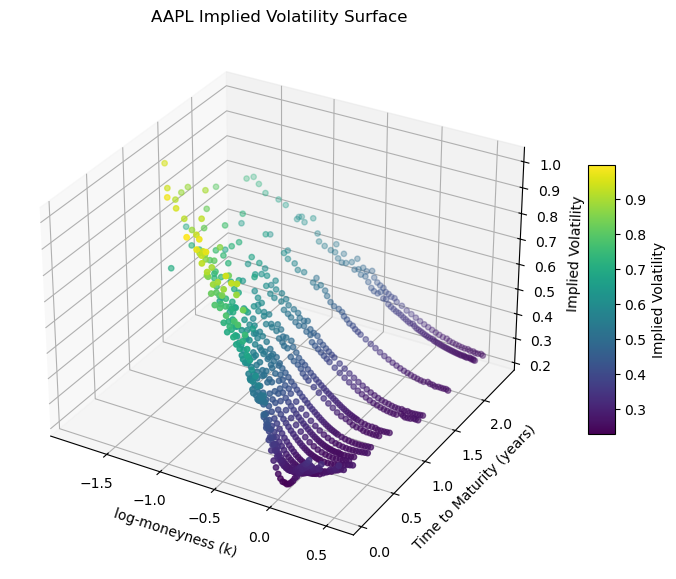

In [8]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df['k']          # log-moneyness
y = df['T_years']    # time to maturity
z = df['iv']         # implied volatility

sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=15)

ax.set_xlabel('log-moneyness (k)')
ax.set_ylabel('Time to Maturity (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('AAPL Implied Volatility Surface')

fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10, label='Implied Volatility')

plt.show()

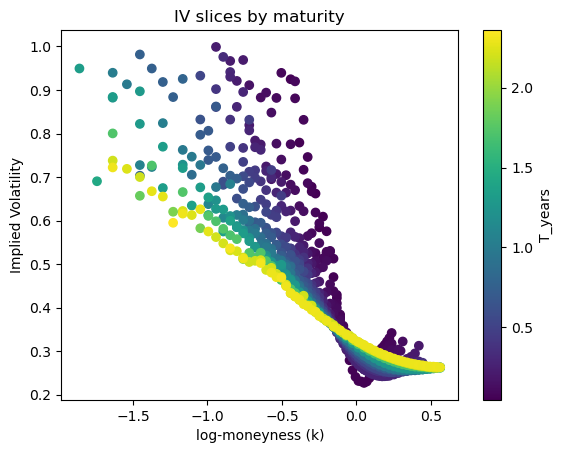

In [9]:
plt.scatter(df['k'], df['iv'], c=df['T_years'], cmap='viridis')
plt.xlabel('log-moneyness (k)')
plt.ylabel('Implied Volatility')
plt.title('IV slices by maturity')
plt.colorbar(label='T_years')
plt.show()

In [10]:
# verifichiamo che il df contenga dati sensati

prova =  black_scholes(S=256.7, K=175, T=0.055, r=0.0386, sigma=0.980, option_type="call", q=0.004)
prova2 = black_scholes(S=256.7, K=170, T=0.209, r=0.0386, sigma=0.607, option_type="call", q=0.004)
prova3 = black_scholes(S=256.7, K=450, T=2.290, r=0.0386, sigma=0.263, option_type="call", q=0.004)
prova4 = black_scholes(S=256.7, K=165, T=0.064, r=0.0386, sigma=0.924, option_type="call", q=0.004)
prova5 = black_scholes(S=256.7, K=235, T=0.200, r=0.0386, sigma=0.318, option_type="call", q=0.004)

print(prova, prova2, prova3, prova4, prova5) # funziona +-2 dollari

82.95487984166195 89.48882062306421 6.967147355715618 92.56943619486424 28.523925441791704


## 3. Heston

In [11]:
# parametri
S = 105              
K = 105                 
T = 0.25                   
r = 0.03   
q = 0.005             
sigma = 0.2        

v0 = 0.04       # varianza iniziale
kappa = 1.5     # velocità di mean reversion
theta = 0.04    # varianza di lungo periodo
sigma_v = 0.3   # vol-of-vol
rho = -0.7      # correlazione


alpha = 1.5   # damping (>0)
q = 0.0       # dividend yield
N = 4096      # punti FFT (tipicamente potenza di 2)
eta = 0.25    # passo in frequenza

In [12]:
'''Heston (integrale diretto)'''


def heston_price(S, K, T, r, v0, kappa, theta, sigma_v, rho, option_type="call", q=0.0,
                 int_upper=150.0):
    
    i = 1j
    a = kappa * theta
    x0 = np.log(S)

    def char_func(phi, Pnum):
        # u e b secondo Heston; Little Trap per stabilità
        u = 0.5 if Pnum == 1 else -0.5 # P_1 e P_2
        b = kappa - rho * sigma_v if Pnum == 1 else kappa

        # d e g (nota: sqrt complessa)
        d = np.sqrt((rho*sigma_v*i*phi - b)**2 - (sigma_v**2)*(2*u*i*phi - phi**2))
        gp = (b - rho*sigma_v*i*phi + d) / (b - rho*sigma_v*i*phi - d)

        # Evita |gp| ~ 1
        # Formulazione 'trap': usa gp così che |gp| < 1
        exp_dT = np.exp(d * T)
        one_minus_gp = 1.0 - gp
        one_minus_gp_exp = 1.0 - gp * exp_dT

        # piccole salvaguardie numeriche
        eps = 1e-14
        one_minus_gp = np.where(np.abs(one_minus_gp) < eps, eps, one_minus_gp)
        one_minus_gp_exp = np.where(np.abs(one_minus_gp_exp) < eps, eps, one_minus_gp_exp)

        C = (r - q) * i * phi * T + (a / (sigma_v**2)) * (
            (b - rho*sigma_v*i*phi + d) * T - 2.0 * np.log(one_minus_gp_exp / one_minus_gp)
        )
        D = ((b - rho*sigma_v*i*phi + d) / (sigma_v**2)) * (
            (1.0 - exp_dT) / one_minus_gp_exp
        )
        return np.exp(C + D * v0 + i * phi * x0)

    def Pj(j):
        # integrando reale; gestiamo la singolarità in 0 implicitamente
        def integrand(phi):
            return np.real(np.exp(-i*phi*np.log(K)) * char_func(phi, j) / (i*phi))
        # integriamo da 0 a un limite alto (tipicamente 100–200)
        val, _ = quad(integrand, 0.0, int_upper, limit=500, epsabs=1e-9, epsrel=1e-7)
        return 0.5 + val/np.pi

    P1 = Pj(1)
    P2 = Pj(2)

    call = S*np.exp(-q*T)*P1 - K*np.exp(-r*T)*P2
    if option_type.lower() == "call":
        return float(call)
    else:
        # Put da parità
        return float(call - S*np.exp(-q*T) + K*np.exp(-r*T))



start_heston = time.time()
call_price_heston = heston_price(S, K, T, r, v0, kappa, theta, sigma_v, rho, option_type="call")
end_heston = time.time()

In [ ]:
'''Heston Carr-Madan'''


def heston_fft(S, K, T, r, v0, kappa, theta, sigma_v, rho,
                     option_type="call", q=0.0,
                     alpha=1.5, N=4096, eta=0.05):
    i = 1j

    # Caratteristica risk-neutral di ln(S_T)
    def phi(u):
        a = kappa * theta
        b_h = kappa
        d = np.sqrt((rho*sigma_v*i*u - b_h)**2 + (sigma_v**2)*(i*u + u**2))
        g = (b_h - rho*sigma_v*i*u + d) / (b_h - rho*sigma_v*i*u - d)

        C = (r - q)*i*u*T + (a/(sigma_v**2)) * (
            (b_h - rho*sigma_v*i*u + d)*T - 2*np.log((1 - g*np.exp(d*T))/(1 - g))
        )
        D = ((b_h - rho*sigma_v*i*u + d)/(sigma_v**2)) * (
            (1 - np.exp(d*T))/(1 - g*np.exp(d*T))
        )
        return np.exp(C + D*v0 + i*u*np.log(S))

    # Griglia in frequenza
    u = np.arange(N) * eta

    # Pesi trapezoidali
    w = np.ones(N)
    w[0] = 0.5
    w[-1] = 0.5
    w *= eta

    # psi(u) di Carr-Madan
    uj = u - i*(alpha + 1.0)
    numerator = np.exp(-r*T) * phi(uj)
    denominator = (alpha**2 + alpha - u**2) + i*(2*alpha + 1.0)*u
    denominator = np.where(np.abs(denominator) < 1e-14, 1e-14, denominator)  # guardia numerica
    psi = numerator / denominator

    # Spaziatura in log-strike
    lam = 2.0*np.pi / (N * eta)                 # passo in k
    k_min = np.log(S) - (N * lam) / 2.0         # shift (inizio griglia)
    k_grid = k_min + np.arange(N) * lam         # griglia di log-strike

    # Input FFT 
    fft_input = np.exp(-1j * k_min * u) * psi * w
    fft_vals = np.fft.fft(fft_input)
    fft_real = np.real(fft_vals)

    # Prezzi delle call su tutta la griglia k
    C_k = (np.exp(-alpha * k_grid) / np.pi) * fft_real

    # Interpola al log-strike desiderato
    k_target = np.log(K)
    if k_target <= k_grid[0]:
        price_call = C_k[0]
    elif k_target >= k_grid[-1]:
        price_call = C_k[-1]
    else:
        idx = np.searchsorted(k_grid, k_target) - 1
        t = (k_target - k_grid[idx]) / (k_grid[idx+1] - k_grid[idx])
        price_call = C_k[idx] * (1 - t) + C_k[idx+1] * t

    if option_type.lower() == "call":
        return float(price_call)
    else:
        # put by parity
        return float(price_call - S*np.exp(-q*T) + K*np.exp(-r*T))



start_heston_fft = time.time()
call_price_heston_fft = heston_fft(S, K, T, r, v0, kappa, theta, sigma_v, rho, option_type="call")
end_heston_fft = time.time()

In [14]:
print(f"Black-Scholes Call Price: {call_price_bs:.4f} (tempo: {end_bs-start_bs:.6f} s)")
print(f"Heston Call Price (int. dir.): {call_price_heston:.4f} (tempo: {end_heston-start_heston:.6f} s)")
print(f"Heston FFT Call Price: {call_price_heston_fft:.4f} (tempo: {end_heston_fft-start_heston_fft:.6f} s)") # ci mette la metà rispetto int diretto

Black-Scholes Call Price: 4.5037 (tempo: 0.000010 s)
Heston Call Price (int. dir.): 4.5183 (tempo: 0.002419 s)
Heston FFT Call Price: 4.5183 (tempo: 0.003008 s)


## 4. Ottimizzazione Heston

In [ ]:
'''def residuals_price(p, df, option_type="call"):
    kappa, theta, sigma_v, rho, v0 = p
    res = []
    for row in df.itertuples(index=False):
        S, K, T, r, q, price_mkt = row.S, row.strike, row.T_years, row.risk_free, row.q_t, row.lastPrice
        price_mod = heston_fft(S, K, T, r, v0, kappa, theta, sigma_v, rho, option_type, q)
        price_mod = max(float(price_mod), 0.0)
        v = row.Vega
        w = v if np.isfinite(v) and v>1e-10 else 1e-10
        res.append((price_mod - price_mkt) * np.sqrt(w))
    # Feller 
    feller_violation = max(0.0, sigma_v**2 - 2.0*kappa*theta)
    res.append(1e4 * feller_violation)
    return np.array(res, float)

def calibrate_heston_price(df, **kwargs):
    return least_squares(residuals_price,
                         kwargs.get("x0",(1.0,0.04,0.30,-0.6,0.04)),
                         bounds=kwargs.get("bounds",((0.01,0.01,0.05,-0.95,0.01),
                                                     (5.00,0.20,1.00, 0.00,0.50))),
                         args=(df, kwargs.get("option_type","call")),
                         loss=kwargs.get("loss","soft_l1"),
                         f_scale=kwargs.get("f_scale",0.01),
                         max_nfev=kwargs.get("max_nfev",150),
                         xtol=1e-8, ftol=1e-8, gtol=1e-8)

res_price = calibrate_heston_price(df)
params = res_price.x

params # kappa, theta, sigma_v, rho, v_0'''

**RISULTATI**

- $\kappa =	1.04368$
- $\theta =	0.08588$
- $\sigma_v =	0.42340$
- $\rho	= -0.54572$
- $v_0	= 0.07385$

Feller al limite.

In [29]:
df.sample()

,lastTradeDate,underlying,S,type,strike,expiration_date,T_years,bid,ask,mid_price,lastPrice,iv,inTheMoney,stock,k,tradeDate,risk_free,q_t,Vega
726,2025-10-06 18:28:01+00:00,AAPL,256.690002,call,220.0,2027-06-17 00:00:00+00:00,1.693782,64.15,64.6,64.375,64.4,0.357444,True,AAPL,-0.154242,2025-10-06,0.0386,0.004,104.322951


In [ ]:
kappa=1.0437 
theta=0.0859 
sigma_v=0.4234 
rho=-0.5457
v0=0.07385 

In [35]:
esempio_H =   heston_fft(S=257, K=220, T=1.694, r=0.0386, v0=0.07385, kappa=1.0437, theta=0.0859, sigma_v=0.4234, rho=-0.5457, option_type="call")
esempio_BS =  black_scholes(S=256.7, K=220, T=1.694, r=0.0386, sigma=0.357, option_type="call", q=0.004)

print('Heston: ', esempio_H)
print('Black-Scholes: ', esempio_BS)

Heston:  65.64503701782846
Black-Scholes:  71.06661537954139
